This notebook is for plotting the comparison with the PC1, Approximated PC1-pattern and the Pearson matrix on those experiments which shows a lower similar_rate then average, such as:

* k562, chrom 22,resolution 1000000 (Flip error)
* hmec, chrom 9, resolution 1000000 (centro error)
* nhek, chrom 9, resolution 1000000 (centro error)
* kbm7, chrom 4, resolution 1000000
* hmec, chrom 4, resolution 1000000


In [1]:
import numpy as np
import pandas as pd
from hicpap import paptools

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
data_store="/media/jordan990301/Samsung_T5/HiC_Datasets/data_for_hicpap/data_store"
cell_line = "k562"
resolution = 1000000
chrom = "22"
ref="hg19"

###
ref_gc=f"../reference_gc/{ref}/{ref}_gc{resolution}_chr{chrom}.txt"
pearson = f"{data_store}/data/rao_2014/juicer_outputs/{cell_line}/{resolution}/pearsons/pearson_chr{chrom}.txt"
pc1 = f"{data_store}/data/rao_2014/juicer_outputs/{cell_line}/{resolution}/eigenvector/pc1_chr{chrom}.txt"

pearson_np = paptools.read_pearson(pearson=pearson)
pc1_df = pd.read_table(pc1, header=None)
pc1_np = pc1_df.fillna(0).values.flatten()
approx_np = paptools.create_approx(pearson_np=pearson_np, method="cxmax")

# Flip track through GC content
def flip_track_gc(track_np: np.ndarray, gc_np: np.ndarray) -> np.ndarray:
    if np.mean(gc_np[track_np > 0]) < np.mean(gc_np[track_np < 0]):
        track_np = -track_np
    return track_np

gc_df = pd.read_table(ref_gc, skiprows=[0], names=["bin", "GC"])
gc_np = gc_df["GC"].values.flatten()

# Remove the last bin to make sure the total_entry_num of pc1_np and approx_np is same as gc_np.
pc1_np = pc1_np[:-1]
approx_np = approx_np[:-1]
pc1_np = flip_track_gc(track_np=pc1_np, gc_np=gc_np)
approx_np = flip_track_gc(track_np=approx_np, gc_np=gc_np)

pc1_np and approx_np has a different valid_entry_num


TypeError: 'NoneType' object is not subscriptable

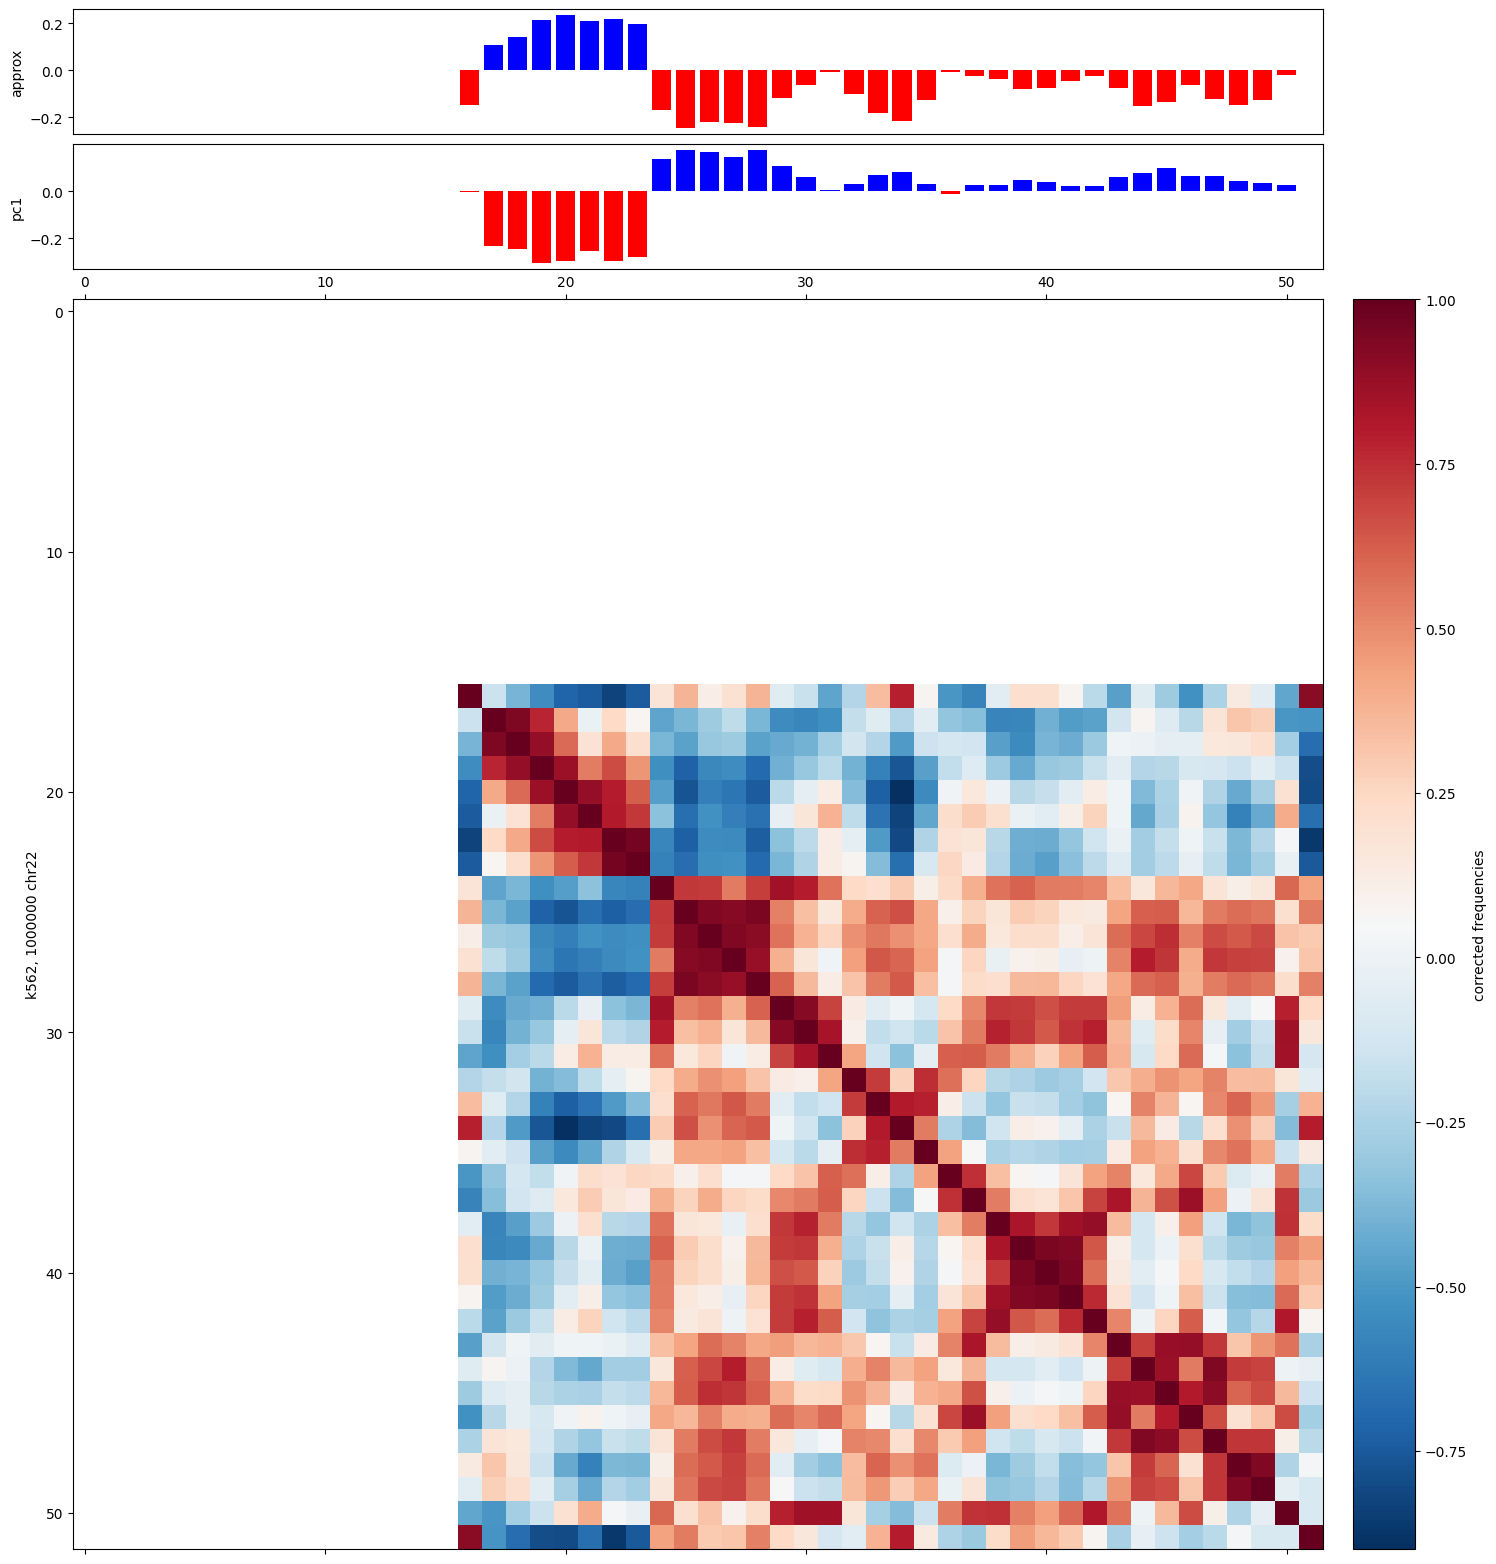

In [3]:
# Settings for pearson_np
f, ax = plt.subplots(
    figsize=(20, 20),
)
im = ax.matshow(
    pearson_np,
    cmap='RdBu_r',
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.3)
plt.colorbar(im, cax=cax, label='corrected frequencies')
ax.set_ylabel(f'{cell_line}, {resolution} chr{chrom}')

#### Settings for pc1_np
ax1 = divider.append_axes("top", size="10%", pad=0.3, sharex=ax)
pc1_x_axis = [i for i in range(0, len(pc1_np))]
pc1_bar_color = ['b' if i > 0 else 'r' for i in pc1_np]
ax1.bar(x=pc1_x_axis, height=pc1_np, color=pc1_bar_color)
ax1.set_ylabel('pc1')
ax1.xaxis.set_visible(False)

#### Settings for approx_np
ax2 = divider.append_axes("top", size="10%", pad=0.1, sharex=ax)
approx_x_axis = [i for i in range(0, len(approx_np))]
approx_bar_color = ['b' if i > 0 else 'r' for i in approx_np]
ax2.bar(x=approx_x_axis, height=approx_np, color=approx_bar_color)
ax2.set_ylabel('approx')
ax2.xaxis.set_visible(False)

#### Settings for pc1_np vs approx_np
similarity_info = paptools.calc_similarity(pc1_np, approx_np)
total_entry_num = similarity_info["total_entry_num"]
print(similarity_info)
plot_x_axis = [i + 1 for i in range(total_entry_num)]
approx_dots = [1 if i > 0 else -1 if i < 0 else 0 for i in approx_np]
pc1_colors_values = [2 if i > 0 else 0 if i < 0 else 1 for i in pc1_np]
pc1_colors = ListedColormap(['r', 'g', 'b'])
scatter_labels = ["PC1 < 0", "PC1 == 0", "PC1 > 0"]

ax3 = divider.append_axes("top", size="10%", pad=0.1, sharex=ax)
scatter_config = ax3.scatter(plot_x_axis, approx_dots, c=pc1_colors_values, cmap=pc1_colors, s=1)
ax3.legend(handles=scatter_config.legend_elements()[0], labels=scatter_labels, fontsize="8", loc="center left")
ax3.xaxis.set_visible(False)